In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
CSV_PATH = "labeled_data.csv"  

In [ ]:
df = pd.read_csv(CSV_PATH)
df = df[["tweet", "class"]].dropna()
df["tweet"] = df["tweet"].astype(str)

In [ ]:
df["label"] = df["class"].isin([0, 1]).astype(np.int32)

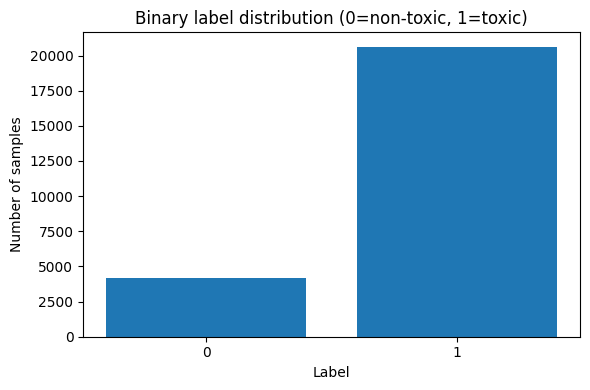

Label counts:
label
0     4163
1    20620


In [ ]:
counts = df["label"].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Binary label distribution (0=non-toxic, 1=toxic)")
plt.xlabel("Label")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

print("Label counts:")
print(counts.to_string())

In [ ]:
_url_re = re.compile(r"https?://\S+|www\.\S+")
_user_re = re.compile(r"@\w+")
_ws_re = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = s.lower()
    s = _url_re.sub(" ", s)
    s = _user_re.sub(" ", s)
    s = s.replace("#", " ")     
    s = _ws_re.sub(" ", s).strip()
    return s

df["text"] = df["tweet"].map(clean_text)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"].values,
    df["label"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["label"].values
)

In [ ]:
USE_AUGMENTATION = True

def random_deletion(words, p=0.1):
    if len(words) <= 2:
        return words
    keep = [w for w in words if np.random.rand() > p]
    return keep if len(keep) > 0 else words

def random_swap(words, n_swaps=1):
    words = words[:]
    for _ in range(n_swaps):
        if len(words) < 2:
            break
        i, j = np.random.randint(0, len(words), size=2)
        words[i], words[j] = words[j], words[i]
    return words

def eda_augment(text, p_del=0.1, n_swaps=1):
    words = text.split()
    words = random_deletion(words, p=p_del)
    words = random_swap(words, n_swaps=n_swaps)
    return " ".join(words)



In [ ]:
if USE_AUGMENTATION:
    unique, freq = np.unique(y_train, return_counts=True)
    freq_map = dict(zip(unique.tolist(), freq.tolist()))
    max_count = max(freq_map.values())

    target = int(0.6 * max_count)

    X_aug, y_aug = [], []
    for label in np.unique(y_train):
        idxs = np.where(y_train == label)[0]
        cur = len(idxs)
        if cur >= target:
            continue

        needed = target - cur
        chosen = np.random.choice(idxs, size=needed, replace=True)
        for i in chosen:
            X_aug.append(eda_augment(X_train[i]))
            y_aug.append(label)

    if len(X_aug) > 0:
        X_train = np.concatenate([X_train, np.array(X_aug, dtype=object)])
        y_train = np.concatenate([y_train, np.array(y_aug, dtype=y_train.dtype)])

    perm = np.random.permutation(len(X_train))
    X_train, y_train = X_train[perm], y_train[perm]

    u2, f2 = np.unique(y_train, return_counts=True)
    print("\nAfter augmentation (train) label counts:", dict(zip(u2.tolist(), f2.tolist())))


After augmentation (train) label counts: {0: 9897, 1: 16496}


In [ ]:
max_tokens = 20000
seq_len = 50

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=seq_len
)
vectorizer.adapt(X_train)

model = tf.keras.Sequential([
    vectorizer,
    tf.keras.layers.Embedding(max_tokens, 64),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]  w
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7322 - loss: 0.5087 - val_accuracy: 0.9331 - val_loss: 0.2379
Epoch 2/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9360 - loss: 0.1878 - val_accuracy: 0.9557 - val_loss: 0.1455
Epoch 3/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9578 - loss: 0.1252 - val_accuracy: 0.9648 - val_loss: 0.1141
Epoch 4/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9694 - loss: 0.0983 - val_accuracy: 0.9644 - val_loss: 0.1067
Epoch 5/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9750 - loss: 0.0800 - val_accuracy: 0.9507 - val_loss: 0.1380



Confusion Matrix (rows=true, cols=pred):
[[ 594  239]
 [ 144 3980]]

Per-class metrics:
Class 0 (non-toxic): precision=0.8049, recall=0.7131, f1=0.7562, support=833
Class 1 (toxic)    : precision=0.9434, recall=0.9651, f1=0.9541, support=4124

Macro average:
precision=0.8741, recall=0.8391, f1=0.8551

Classification report:
              precision    recall  f1-score   support

           0     0.8049    0.7131    0.7562       833
           1     0.9434    0.9651    0.9541      4124

    accuracy                         0.9227      4957
   macro avg     0.8741    0.8391    0.8551      4957
weighted avg     0.9201    0.9227    0.9208      4957



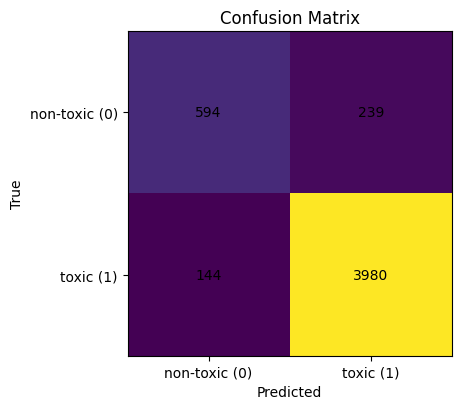

In [ ]:
y_prob = model.predict(X_test, verbose=0).reshape(-1)

THRESHOLD = 0.5
y_pred = (y_prob >= THRESHOLD).astype(np.int32)

cm = confusion_matrix(y_test, y_pred)
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

print("\nPer-class metrics:")
print(f"Class 0 (non-toxic): precision={prec[0]:.4f}, recall={rec[0]:.4f}, f1={f1[0]:.4f}, support={support[0]}")
print(f"Class 1 (toxic)    : precision={prec[1]:.4f}, recall={rec[1]:.4f}, f1={f1[1]:.4f}, support={support[1]}")

print("\nMacro average:")
print(f"precision={prec_macro:.4f}, recall={rec_macro:.4f}, f1={f1_macro:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(4.8, 4.2))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1], ["non-toxic (0)", "toxic (1)"])
plt.yticks([0, 1], ["non-toxic (0)", "toxic (1)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

In [ ]:
analysis_df = pd.DataFrame({
    "text": X_test,      
    "y_true": y_test,
    "y_pred": y_pred,
    "p_toxic": y_prob
})

fp = analysis_df[(analysis_df["y_true"] == 0) & (analysis_df["y_pred"] == 1)].copy()

fn = analysis_df[(analysis_df["y_true"] == 1) & (analysis_df["y_pred"] == 0)].copy()


fp = fp.sort_values("p_toxic", ascending=False)

fn = fn.sort_values("p_toxic", ascending=True)

N_SHOW = 20  

def print_examples(title, df_sub, n=20, max_chars=240):
    print(f"\n{title} (showing up to {n} examples)")
    print("-" * (len(title) + 26))
    if len(df_sub) == 0:
        print("None 🎉")
        return
    for i, row in df_sub.head(n).iterrows():
        txt = row["text"]
        if len(txt) > max_chars:
            txt = txt[:max_chars] + "..."
        print(f"p_toxic={row['p_toxic']:.3f} | true={row['y_true']} pred={row['y_pred']} | {txt}")

print_examples("False Positives (non-toxic → predicted toxic)", fp, n=N_SHOW)
print_examples("False Negatives (toxic → predicted non-toxic)", fn, n=N_SHOW)


False Positives (non-toxic → predicted toxic) (showing up to 20 examples)
-----------------------------------------------------------------------
p_toxic=1.000 | true=0 pred=1 | laat zihni ozdil met rust jullie gemene trollen, hoe durven jullie zijn mening in twijfel te nemen! zijn zegje is wet en*kuch**kuch*. .water
p_toxic=1.000 | true=0 pred=1 | nee dat is na langdurig gepest worden.zoals ik al zei:in d kiem smoren.is ook vb voor t kind hoe je moet optreden
p_toxic=1.000 | true=0 pred=1 | e250 5.4 motor and tranny i have a 2008 5.4 triton motor and transmission with 5,200 miles that came off a e250...
p_toxic=1.000 | true=0 pred=1 | rotherdam rapejihad coverup: young girls sacrificed on altar of political correctness in favor pf paki pedo gangs
p_toxic=1.000 | true=0 pred=1 | rt : dreigdwergen, haatsmurfen en de roze khmer: hoe twitter een slagveld werd via
p_toxic=1.000 | true=0 pred=1 | steek d morele vinger maar in j neus, zelfde soort types bij nato stenigt vrouwen by bosjes
p_

In [ ]:
SAVE_ERRORS = True
if SAVE_ERRORS:
    fp.to_csv("false_positives.csv")
    fn.to_csv("false_negatives.csv")
    print("\nSaved: false_positives.csv and false_negatives.csv")


Saved: false_positives.csv and false_negatives.csv


In [ ]:
def predict_toxic(texts):
    cleaned = np.array([clean_text(t) for t in texts], dtype=object)
    probs = model.predict(cleaned, verbose=0).reshape(-1)
    preds = (probs >= THRESHOLD).astype(int)
    return probs, preds

samples = [
    "I love this, it's amazing!",
    "You are stupid and disgusting.",
    "Let's meet tomorrow and talk."
]
probs, preds = predict_toxic(samples)

print("\nSample predictions:")
for s, p, c in zip(samples, probs, preds):
    print(f"- {s!r} -> toxic_prob={p:.3f}, pred={c}")


Sample predictions:
- "I love this, it's amazing!" -> toxic_prob=0.070, pred=0
- 'You are stupid and disgusting.' -> toxic_prob=0.451, pred=0
- "Let's meet tomorrow and talk." -> toxic_prob=0.051, pred=0


In [ ]:
from collections import Counter

INJECT_WORD = "fucking"
INJECT_MODE = "non_toxic"  

INJECT_STYLE = "append"


THRESHOLD = 0.5  

In [ ]:
def inject_word(text: str, word: str, style: str = "append") -> str:
    """Insert a word into the text in a controllable way."""
    text = str(text).strip()
    if not text:
        return word

    toks = text.split()

    if style == "prepend":
        return word + " " + text
    elif style == "middle":
        if len(toks) <= 1:
            return text + " " + word
        return " ".join([toks[0], word] + toks[1:])
    else:  
        return text + " " + word


In [ ]:
X_test_injected = X_test.copy()

if INJECT_MODE == "all":
    mask = np.ones_like(y_test, dtype=bool)
elif INJECT_MODE == "non_toxic":
    mask = (y_test == 0)
elif INJECT_MODE == "toxic":
    mask = (y_test == 1)
else:
    raise ValueError("INJECT_MODE must be one of: 'all', 'non_toxic', 'toxic'")

for i in range(len(X_test_injected)):
    if mask[i]:
        X_test_injected[i] = inject_word(X_test_injected[i], INJECT_WORD, style=INJECT_STYLE)

In [ ]:
y_prob_inj = model.predict(X_test_injected, verbose=0).reshape(-1)
y_pred_inj = (y_prob_inj >= THRESHOLD).astype(np.int32)


cm_before = confusion_matrix(y_test, y_pred)
cm_after  = confusion_matrix(y_test, y_pred_inj)

prec_b, rec_b, f1_b, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
prec_a, rec_a, f1_a, _ = precision_recall_fscore_support(y_test, y_pred_inj, average="binary")

In [23]:
print("\n================ Injection Experiment ================")
print(f"Injected word: {INJECT_WORD!r} | mode={INJECT_MODE} | style={INJECT_STYLE} | threshold={THRESHOLD}")
print("------------------------------------------------------")

print("\nConfusion matrix BEFORE (rows=true, cols=pred):")
print(cm_before)

print("\nConfusion matrix AFTER injection (rows=true, cols=pred):")
print(cm_after)

print("\nBinary metrics (positive class = toxic=1)")
print(f"BEFORE: precision={prec_b:.4f}, recall={rec_b:.4f}, f1={f1_b:.4f}")
print(f"AFTER : precision={prec_a:.4f}, recall={rec_a:.4f}, f1={f1_a:.4f}")

mis_before = (y_pred != y_test)
mis_after  = (y_pred_inj != y_test)

print("\nMisclassifications:")
print(f"Before: {mis_before.sum()} / {len(y_test)}")
print(f"After : {mis_after.sum()} / {len(y_test)}")
print(f"Change: {mis_after.sum() - mis_before.sum():+d}")


================ Injection Experiment ================
Injected word: 'fucking' | mode=non_toxic | style=append | threshold=0.5
------------------------------------------------------

Confusion matrix BEFORE (rows=true, cols=pred):
[[ 594  239]
 [ 144 3980]]

Confusion matrix AFTER injection (rows=true, cols=pred):
[[ 127  706]
 [ 144 3980]]

Binary metrics (positive class = toxic=1)
BEFORE: precision=0.9434, recall=0.9651, f1=0.9541
AFTER : precision=0.8493, recall=0.9651, f1=0.9035

Misclassifications:
Before: 383 / 4957
After : 850 / 4957
Change: +467


In [ ]:
newly_mis = (~mis_before) & (mis_after)      
fixed_mis = (mis_before) & (~mis_after)      
still_mis = (mis_before) & (mis_after)       

print("\nError transitions:")
print(f"Newly misclassified after injection: {newly_mis.sum()}")
print(f"Fixed by injection:                  {fixed_mis.sum()}")
print(f"Still misclassified:                 {still_mis.sum()}")


Error transitions:
Newly misclassified after injection: 467
Fixed by injection:                  0
Still misclassified:                 383


In [ ]:
compare_df = pd.DataFrame({
    "text_before": X_test,
    "text_after": X_test_injected,
    "y_true": y_test,
    "pred_before": y_pred,
    "p_before": y_prob,
    "pred_after": y_pred_inj,
    "p_after": y_prob_inj,
    "newly_mis": newly_mis,
    "fixed_mis": fixed_mis,
    "still_mis": still_mis
})

In [ ]:
new_mis_df = compare_df[compare_df["newly_mis"]].copy().sort_values("p_after", ascending=False)
fixed_df   = compare_df[compare_df["fixed_mis"]].copy().sort_values("p_before", ascending=False)
still_df   = compare_df[compare_df["still_mis"]].copy()

N_SHOW = 15

In [27]:
def show_rows(title, subdf, n=15, max_chars=220):
    print(f"\n{title} (top {min(n, len(subdf))})")
    print("=" * (len(title) + 10))
    if len(subdf) == 0:
        print("None 🎉")
        return
    for _, r in subdf.head(n).iterrows():
        tb = r["text_before"]
        ta = r["text_after"]
        if len(tb) > max_chars: tb = tb[:max_chars] + "..."
        if len(ta) > max_chars: ta = ta[:max_chars] + "..."
        print(f"true={int(r['y_true'])} | before: pred={int(r['pred_before'])} p={r['p_before']:.3f} "
              f"| after: pred={int(r['pred_after'])} p={r['p_after']:.3f}")
        print(f"  before: {tb}")
        print(f"  after : {ta}")
        print("-" * 60)

In [28]:
show_rows("NEWLY MISCLASSIFIED after injection", new_mis_df, n=N_SHOW)
show_rows("FIXED by injection (was wrong, now correct)", fixed_df, n=N_SHOW)


NEWLY MISCLASSIFIED after injection (top 15)
true=0 | before: pred=0 p=0.497 | after: pred=1 p=0.990
  before: thou shall not mock ryan(the future)kelly
  after : thou shall not mock ryan(the future)kelly fucking
------------------------------------------------------------
true=0 | before: pred=0 p=0.488 | after: pred=1 p=0.990
  before: ho ho ho.
  after : ho ho ho. fucking
------------------------------------------------------------
true=0 | before: pred=0 p=0.487 | after: pred=1 p=0.990
  before: i hate hashtag activism. no lie. i think 95% of it is trash.
  after : i hate hashtag activism. no lie. i think 95% of it is trash. fucking
------------------------------------------------------------
true=0 | before: pred=0 p=0.491 | after: pred=1 p=0.990
  before: i think about the fact that dinosaurs evolved into birds every time i eat chicken. dinosaurs are delicious.
  after : i think about the fact that dinosaurs evolved into birds every time i eat chicken. dinosaurs are delicious. f

In [ ]:
STOPWORDS = {
    "the", "a", "an", "and", "or", "to", "of", "in", "on", "for", "is", "it", "this", "that",
    "i", "you", "me", "my", "we", "they", "he", "she", "them", "him", "her", "are", "was", "were",
    "be", "been", "with", "at", "as", "by", "from", "but", "not"
}

_word_re = re.compile(r"[a-z']+")

In [30]:
def top_words(texts, k=25, stopwords=STOPWORDS):
    cnt = Counter()
    for t in texts:
        for w in _word_re.findall(str(t).lower()):
            if w not in stopwords:
                cnt[w] += 1
    return cnt.most_common(k)

In [ ]:
mis_texts_before = compare_df[mis_before]["text_before"].values
mis_texts_after  = compare_df[mis_after]["text_after"].values
new_texts_after  = compare_df[newly_mis]["text_after"].values

print("\nTop words in MISCLASSIFIED (BEFORE injection):")
print(top_words(mis_texts_before, k=25))

print("\nTop words in MISCLASSIFIED (AFTER injection):")
print(top_words(mis_texts_after, k=25))

print("\nTop words in NEWLY MISCLASSIFIED (AFTER injection):")
print(top_words(new_texts_after, k=25))

SAVE_COMPARISON = True
if SAVE_COMPARISON:
    compare_df.to_csv("injection_misclassification_comparison.csv")
    print("\nSaved: injection_misclassification_comparison.csv")


Top words in MISCLASSIFIED (BEFORE injection):
[('rt', 119), ('trash', 54), ('like', 39), ('just', 30), ('so', 21), ('all', 21), ('have', 21), ('your', 21), ('who', 20), ('white', 19), ("it's", 18), ('what', 18), ('no', 18), ('ho', 17), ('amp', 17), ('if', 16), ('u', 16), ('out', 16), ("i'm", 15), ('charlie', 13), ('about', 13), ('s', 12), ('up', 12), ('ghetto', 12), ('bird', 12)]

Top words in MISCLASSIFIED (AFTER injection):
[('fucking', 709), ('rt', 264), ('trash', 144), ('like', 65), ('bird', 52), ('just', 50), ("it's", 47), ('your', 47), ('out', 42), ('so', 41), ('all', 41), ('charlie', 39), ('have', 39), ('no', 38), ('yellow', 32), ("don't", 31), ('about', 31), ('if', 31), ('who', 30), ('get', 30), ('amp', 30), ("i'm", 30), ('up', 30), ('when', 29), ('colored', 29)]

Top words in NEWLY MISCLASSIFIED (AFTER injection):
[('fucking', 467), ('rt', 145), ('trash', 90), ('bird', 40), ("it's", 29), ('like', 26), ('charlie', 26), ('your', 26), ('out', 26), ('yellow', 25), ('get', 23), (

In [32]:
INJECT_WORD = "stupid"
INJECT_MODE = "non_toxic"  
INJECT_STYLE = "append"
THRESHOLD = 0.5  

In [ ]:
X_test_injected = X_test.copy()

if INJECT_MODE == "all":
    mask = np.ones_like(y_test, dtype=bool)
elif INJECT_MODE == "non_toxic":
    mask = (y_test == 0)
elif INJECT_MODE == "toxic":
    mask = (y_test == 1)
else:
    raise ValueError("INJECT_MODE must be one of: 'all', 'non_toxic', 'toxic'")

for i in range(len(X_test_injected)):
    if mask[i]:
        X_test_injected[i] = inject_word(X_test_injected[i], INJECT_WORD, style=INJECT_STYLE)

In [ ]:
y_prob_inj = model.predict(X_test_injected, verbose=0).reshape(-1)
y_pred_inj = (y_prob_inj >= THRESHOLD).astype(np.int32)

cm_before = confusion_matrix(y_test, y_pred)
cm_after  = confusion_matrix(y_test, y_pred_inj)

prec_b, rec_b, f1_b, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
prec_a, rec_a, f1_a, _ = precision_recall_fscore_support(y_test, y_pred_inj, average="binary")

In [35]:
print("\n================ Injection Experiment ================")
print(f"Injected word: {INJECT_WORD!r} | mode={INJECT_MODE} | style={INJECT_STYLE} | threshold={THRESHOLD}")
print("------------------------------------------------------")

print("\nConfusion matrix BEFORE (rows=true, cols=pred):")
print(cm_before)

print("\nConfusion matrix AFTER injection (rows=true, cols=pred):")
print(cm_after)

print("\nBinary metrics (positive class = toxic=1)")
print(f"BEFORE: precision={prec_b:.4f}, recall={rec_b:.4f}, f1={f1_b:.4f}")
print(f"AFTER : precision={prec_a:.4f}, recall={rec_a:.4f}, f1={f1_a:.4f}")

mis_before = (y_pred != y_test)
mis_after  = (y_pred_inj != y_test)

print("\nMisclassifications:")
print(f"Before: {mis_before.sum()} / {len(y_test)}")
print(f"After : {mis_after.sum()} / {len(y_test)}")
print(f"Change: {mis_after.sum() - mis_before.sum():+d}")


================ Injection Experiment ================
Injected word: 'stupid' | mode=non_toxic | style=append | threshold=0.5
------------------------------------------------------

Confusion matrix BEFORE (rows=true, cols=pred):
[[ 594  239]
 [ 144 3980]]

Confusion matrix AFTER injection (rows=true, cols=pred):
[[ 521  312]
 [ 144 3980]]

Binary metrics (positive class = toxic=1)
BEFORE: precision=0.9434, recall=0.9651, f1=0.9541
AFTER : precision=0.9273, recall=0.9651, f1=0.9458

Misclassifications:
Before: 383 / 4957
After : 456 / 4957
Change: +73


In [ ]:
newly_mis = (~mis_before) & (mis_after)      
fixed_mis = (mis_before) & (~mis_after)      
still_mis = (mis_before) & (mis_after)       

print("\nError transitions:")
print(f"Newly misclassified after injection: {newly_mis.sum()}")
print(f"Fixed by injection:                  {fixed_mis.sum()}")
print(f"Still misclassified:                 {still_mis.sum()}")


Error transitions:
Newly misclassified after injection: 73
Fixed by injection:                  0
Still misclassified:                 383


In [ ]:
compare_df = pd.DataFrame({
    "text_before": X_test,
    "text_after": X_test_injected,
    "y_true": y_test,
    "pred_before": y_pred,
    "p_before": y_prob,
    "pred_after": y_pred_inj,
    "p_after": y_prob_inj,
    "newly_mis": newly_mis,
    "fixed_mis": fixed_mis,
    "still_mis": still_mis
})

In [ ]:
new_mis_df = compare_df[compare_df["newly_mis"]].copy().sort_values("p_after", ascending=False)
fixed_df   = compare_df[compare_df["fixed_mis"]].copy().sort_values("p_before", ascending=False)
still_df   = compare_df[compare_df["still_mis"]].copy()

N_SHOW = 15

In [39]:
show_rows("NEWLY MISCLASSIFIED after injection", new_mis_df, n=N_SHOW)
show_rows("FIXED by injection (was wrong, now correct)", fixed_df, n=N_SHOW)


NEWLY MISCLASSIFIED after injection (top 15)
true=0 | before: pred=0 p=0.497 | after: pred=1 p=0.747
  before: thou shall not mock ryan(the future)kelly
  after : thou shall not mock ryan(the future)kelly stupid
------------------------------------------------------------
true=0 | before: pred=0 p=0.491 | after: pred=1 p=0.742
  before: i think about the fact that dinosaurs evolved into birds every time i eat chicken. dinosaurs are delicious.
  after : i think about the fact that dinosaurs evolved into birds every time i eat chicken. dinosaurs are delicious. stupid
------------------------------------------------------------
true=0 | before: pred=0 p=0.488 | after: pred=1 p=0.740
  before: ho ho ho.
  after : ho ho ho. stupid
------------------------------------------------------------
true=0 | before: pred=0 p=0.487 | after: pred=1 p=0.739
  before: i hate hashtag activism. no lie. i think 95% of it is trash.
  after : i hate hashtag activism. no lie. i think 95% of it is trash. stup

In [ ]:
STOPWORDS = {
    "the", "a", "an", "and", "or", "to", "of", "in", "on", "for", "is", "it", "this", "that",
    "i", "you", "me", "my", "we", "they", "he", "she", "them", "him", "her", "are", "was", "were",
    "be", "been", "with", "at", "as", "by", "from", "but", "not"
}

_word_re = re.compile(r"[a-z']+")

In [ ]:
mis_texts_before = compare_df[mis_before]["text_before"].values
mis_texts_after  = compare_df[mis_after]["text_after"].values
new_texts_after  = compare_df[newly_mis]["text_after"].values

print("\nTop words in MISCLASSIFIED (BEFORE injection):")
print(top_words(mis_texts_before, k=25))

print("\nTop words in MISCLASSIFIED (AFTER injection):")
print(top_words(mis_texts_after, k=25))

print("\nTop words in NEWLY MISCLASSIFIED (AFTER injection):")
print(top_words(new_texts_after, k=25))


SAVE_COMPARISON = True
if SAVE_COMPARISON:
    compare_df.to_csv("injection_misclassification_comparison1.csv")
    print("\nSaved: injection_misclassification_comparison1.csv")


Top words in MISCLASSIFIED (BEFORE injection):
[('rt', 119), ('trash', 54), ('like', 39), ('just', 30), ('so', 21), ('all', 21), ('have', 21), ('your', 21), ('who', 20), ('white', 19), ("it's", 18), ('what', 18), ('no', 18), ('ho', 17), ('amp', 17), ('if', 16), ('u', 16), ('out', 16), ("i'm", 15), ('charlie', 13), ('about', 13), ('s', 12), ('up', 12), ('ghetto', 12), ('bird', 12)]

Top words in MISCLASSIFIED (AFTER injection):
[('stupid', 314), ('rt', 144), ('trash', 66), ('like', 41), ('just', 36), ('have', 28), ('all', 24), ('no', 24), ('so', 23), ('your', 23), ("it's", 22), ('ho', 22), ('who', 20), ('what', 20), ('out', 20), ('white', 19), ("i'm", 19), ('amp', 18), ('if', 18), ('u', 18), ('about', 17), ('ghetto', 16), ('lol', 14), ('up', 14), ('only', 14)]

Top words in NEWLY MISCLASSIFIED (AFTER injection):
[('stupid', 74), ('rt', 25), ('trash', 12), ('have', 7), ('no', 6), ('get', 6), ('just', 6), ('take', 5), ('ho', 5), ('only', 5), ('time', 4), ('think', 4), ('out', 4), ("it's"